In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/aml2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CrimeGraphBuilder:
    """Builds graphs where events are nodes with action/object/location features."""
    
    def __init__(self):
        self.action_encoder = LabelEncoder()
        self.crime_encoder = LabelEncoder()
        self.object_encoder = LabelEncoder()
        self.location_encoder = LabelEncoder()
        self.fitted = False

    def _safe_encode(self, encoder: LabelEncoder, value, field_name: str = "") -> int:
        """
        Encode a single value with a fitted LabelEncoder.
        If the value was not seen during fitting, map it to a fallback class
        instead of raising ValueError.
        """
        value = str(value)
        classes = list(encoder.classes_)

        if value not in classes:
            print(f"[WARN] Unknown {field_name} label '{value}'. Using fallback.")
            # Prefer an explicit fallback class if you have one
            if "<PAD>" in classes:
                value = "<PAD>"
            elif "other" in classes:
                value = "other"
            elif "unknown" in classes:
                value = "unknown"
            else:
                # Last resort: first known class
                value = classes[0]

        return int(encoder.transform([value])[0])
        
    def fit(self, df: pd.DataFrame):
        self.action_encoder.fit(df['action'].unique().tolist() + ['<PAD>'])
        self.crime_encoder.fit(df['crime_type'].unique())
        self.object_encoder.fit(df['object'].unique().tolist() + ['<PAD>'])
        self.location_encoder.fit(df['location'].unique().tolist() + ['<PAD>'])
        
        self.n_actions = len(self.action_encoder.classes_)
        self.n_crimes = len(self.crime_encoder.classes_)
        self.n_objects = len(self.object_encoder.classes_)
        self.n_locations = len(self.location_encoder.classes_)
        self.fitted = True

    def build_graph(self, scene_df: pd.DataFrame) -> Data:
        scene_df = scene_df.sort_values('event_id').reset_index(drop=True)
        n_events = len(scene_df)
        
        actions, objects, locations = [], [], []
        for _, event in scene_df.iterrows():
            actions.append(self._safe_encode(self.action_encoder, event['action'], "action"))
            objects.append(self._safe_encode(self.object_encoder, event['object'], "object"))
            locations.append(self._safe_encode(self.location_encoder, event['location'], "location"))
        
        # Fully connected graph
        edge_src, edge_dst = [], []
        for i in range(n_events):
            for j in range(n_events):
                if i != j:
                    edge_src.append(i)
                    edge_dst.append(j)
        
        if len(edge_src) == 0:
            edge_src, edge_dst = [0], [0]
        
        data = Data()
        data.action = torch.tensor(actions, dtype=torch.long)
        data.object = torch.tensor(objects, dtype=torch.long)
        data.location = torch.tensor(locations, dtype=torch.long)
        data.edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
        data.y = torch.tensor(
            [self.crime_encoder.transform([scene_df['crime_type'].iloc[0]])[0]],
            dtype=torch.long
        )
        data.batch = torch.zeros(n_events, dtype=torch.long)
        data.num_nodes = n_events
        data.metadata = {
            'suspect': scene_df['suspect'].iloc[0],
            'victim': scene_df['victim'].iloc[0],
            'persons': list(pd.concat([scene_df['suspect'], scene_df['victim']]).unique()),
            'objects': list(scene_df['object'].unique()),
            'locations': list(scene_df['location'].unique()),
            'n_events': n_events
        }
        return data
    
    def process_dataset(self, df: pd.DataFrame) -> List[Data]:
        if not self.fitted:
            self.fit(df)
        return [self.build_graph(df[df['scene_id'] == sid]) for sid in df['scene_id'].unique()]


In [3]:
class CrimeGNN(nn.Module):
    """GNN with embeddings + one-hot actions for crime classification."""
    
    def __init__(self, n_actions: int, n_objects: int, n_locations: int, 
                 n_crimes: int, embed_dim: int = 32, hidden_dim: int = 128):
        super().__init__()
        self.n_crimes = n_crimes
        self.n_actions = n_actions
        
        self.action_embed = nn.Embedding(n_actions, embed_dim)
        self.object_embed = nn.Embedding(n_objects, embed_dim)
        self.location_embed = nn.Embedding(n_locations, embed_dim)
        
        input_dim = embed_dim * 3 + n_actions
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 + n_actions, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, n_crimes)
        )
        
        self.suspect_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, data: Data) -> Dict[str, torch.Tensor]:
        action_emb = self.action_embed(data.action)
        object_emb = self.object_embed(data.object)
        location_emb = self.location_embed(data.location)
        action_onehot = F.one_hot(data.action, self.n_actions).float()
        
        x = torch.cat([action_emb, object_emb, location_emb, action_onehot], dim=-1)
        x = F.relu(self.input_proj(x))
        
        x1 = F.dropout(F.relu(self.norm1(self.conv1(x, data.edge_index))), p=0.3, training=self.training)
        x = x + x1
        x2 = F.dropout(F.relu(self.norm2(self.conv2(x, data.edge_index))), p=0.3, training=self.training)
        x = x + x2
        x3 = F.relu(self.norm3(self.conv3(x, data.edge_index)))
        x = x + x3
        
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long)
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        action_global = global_max_pool(action_onehot, batch)
        x_graph = torch.cat([x_mean, x_max, action_global], dim=-1)
        
        return {
            'crime_logits': self.classifier(x_graph),
            'suspect_scores': self.suspect_predictor(x).squeeze(-1),
            'node_embeddings': x,
            'graph_embedding': x_graph
        }



In [13]:
class CrimeGNNTrainer:
    """Trainer with comprehensive metrics logging."""
    
    def __init__(self, model, lr=0.005, weight_decay=1e-4, save_dir="results"):
        self.model = model
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        self.criterion = nn.CrossEntropyLoss()  # Will add class weights later if needed
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
        self.history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        self.best_acc = 0
        self.best_state = None
    
    def compute_class_weights(self, graphs: List[Data]) -> torch.Tensor:
        """Compute class weights for imbalanced data."""
        labels = [graph.y.item() for graph in graphs]
        from collections import Counter
        counts = Counter(labels)
        n_samples = len(labels)
        n_classes = len(counts)
        
        # Compute weights: more weight for rare classes
        weights = torch.ones(n_classes)
        for cls, count in counts.items():
            weights[cls] = n_samples / (n_classes * count)
        
        return weights
        
    def train_epoch(self, graphs: List[Data]) -> Tuple[float, float]:
        self.model.train()
        total_loss, correct = 0, 0
        
        for idx in np.random.permutation(len(graphs)):
            data = graphs[idx]
            self.optimizer.zero_grad()
            out = self.model(data)
            loss = self.criterion(out['crime_logits'], data.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            total_loss += loss.item()
            correct += (out['crime_logits'].argmax(dim=1) == data.y).sum().item()
        
        self.scheduler.step()
        return total_loss / len(graphs), correct / len(graphs)
    
    @torch.no_grad()
    def evaluate(self, graphs: List[Data]) -> Tuple[float, float]:
        self.model.eval()
        total_loss, correct = 0, 0
        for data in graphs:
            out = self.model(data)
            total_loss += self.criterion(out['crime_logits'], data.y).item()
            correct += (out['crime_logits'].argmax(dim=1) == data.y).sum().item()
        return total_loss / len(graphs), correct / len(graphs)
    
    def fit(self, train_graphs, val_graphs, epochs=200, patience=40, verbose=True):
        # Compute class weights
        class_weights = self.compute_class_weights(train_graphs)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        if verbose:
            print(f"Class weights: {class_weights.numpy()}")
        
        no_improve = 0
        
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_graphs)
            val_loss, val_acc = self.evaluate(val_graphs)
            
            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            if val_acc > self.best_acc:
                self.best_acc = val_acc
                self.best_state = {k: v.clone() for k, v in self.model.state_dict().items()}
                no_improve = 0
            else:
                no_improve += 1
            
            if verbose and epoch % 20 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")
            
            if no_improve >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
        
        if self.best_state:
            self.model.load_state_dict(self.best_state)
        
        self._save_artifacts()
        return self.history
    
    def _save_artifacts(self):
        # Save history
        pd.DataFrame(self.history).to_csv(os.path.join(self.save_dir, "training_history.csv"), index=False)
        
        # Save model
        torch.save(self.best_state, os.path.join(self.save_dir, "model_test1.pt"))
        
        # Plot training curves
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        axes[0].plot(self.history['epoch'], self.history['train_loss'], 'b-', label='Train')
        axes[0].plot(self.history['epoch'], self.history['val_loss'], 'r-', label='Val')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training & Validation Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(self.history['epoch'], self.history['train_acc'], 'b-', label='Train')
        axes[1].plot(self.history['epoch'], self.history['val_acc'], 'r-', label='Val')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training & Validation Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, "training_curves.png"), dpi=150)
        plt.close()
        
        print(f"Artifacts saved to {self.save_dir}/")



In [5]:
class BaselineComparison:
    """Run and compare all baseline models."""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.results = {}
        
    def _prepare_features(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """Create tabular features for baselines."""
        scene_features, scene_labels = [], []
        
        for scene_id in df['scene_id'].unique():
            scene = df[df['scene_id'] == scene_id]
            features = {
                'n_events': len(scene),
                'n_unique_actions': scene['action'].nunique(),
                'n_unique_objects': scene['object'].nunique(),
            }
            for action in self.df['action'].unique():
                features[f'action_{action}'] = int(action in scene['action'].values)
            for obj in self.df['object'].unique():
                features[f'object_{obj}'] = int(obj in scene['object'].values)
            
            scene_features.append(features)
            scene_labels.append(scene['crime_type'].iloc[0])
        
        X = pd.DataFrame(scene_features).values
        y = LabelEncoder().fit_transform(scene_labels)
        return X, y
    
    def run_all(self, train_df: pd.DataFrame, test_df: pd.DataFrame, verbose=True) -> pd.DataFrame:
        X_train, y_train = self._prepare_features(train_df)
        X_test, y_test = self._prepare_features(test_df)
        
        if verbose:
            print("\n" + "="*50)
            print("BASELINE COMPARISON")
            print("="*50)
        
        # Logistic Regression
        lr = LogisticRegression(max_iter=1000, random_state=42)
        lr.fit(X_train, y_train)
        self.results['Logistic Regression'] = {'accuracy': lr.score(X_test, y_test)}
        
        # Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        self.results['Random Forest'] = {'accuracy': rf.score(X_test, y_test)}
        
        if verbose:
            for name, res in self.results.items():
                print(f"{name}: {res['accuracy']:.3f}")
        
        return pd.DataFrame([{'Model': k, 'Accuracy': v['accuracy']} for k, v in self.results.items()])
    
    def add_gnn_result(self, accuracy: float):
        self.results['GNN (Ours)'] = {'accuracy': accuracy}
    
    def plot_comparison(self, save_path: str = None):
        models = list(self.results.keys())
        accs = [self.results[m]['accuracy'] for m in models]
        colors = ['#E74C3C' if 'GNN' in m else '#3498DB' for m in models]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(models, accs, color=colors, alpha=0.8)
        ax.set_ylabel('Accuracy')
        ax.set_title('Model Comparison: Crime Type Classification')
        ax.set_ylim(0, 1.1)
        
        for bar, acc in zip(bars, accs):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{acc:.3f}', ha='center')
        
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.close()
        return fig



In [6]:
class HypothesisGenerator:
    """Generate and visualize crime hypotheses."""
    
    def __init__(self, model, graph_builder):
        self.model = model
        self.graph_builder = graph_builder
        
    @torch.no_grad()
    def generate(self, scene_df: pd.DataFrame) -> Dict:
        self.model.eval()
        graph = self.graph_builder.build_graph(scene_df)
        output = self.model(graph)
        
        crime_probs = F.softmax(output['crime_logits'], dim=1).squeeze().numpy()
        crime_types = self.graph_builder.crime_encoder.classes_
        
        return {
            'crime_predictions': {ct: float(crime_probs[i]) for i, ct in enumerate(crime_types)},
            'top_prediction': crime_types[np.argmax(crime_probs)],
            'confidence': float(crime_probs.max()),
            'actual_crime': scene_df['crime_type'].iloc[0]
        }
    
    def visualize(self, scene_df: pd.DataFrame, save_path: str = None):
        hypothesis = self.generate(scene_df)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        crimes = list(hypothesis['crime_predictions'].keys())
        probs = list(hypothesis['crime_predictions'].values())
        colors = ['#E74C3C' if c == hypothesis['actual_crime'] else '#3498DB' for c in crimes]
        
        bars = ax.barh(crimes, probs, color=colors, alpha=0.8)
        ax.set_xlabel('Probability')
        ax.set_title(f"Crime Type Prediction\nActual: {hypothesis['actual_crime']} | Predicted: {hypothesis['top_prediction']}")
        ax.set_xlim(0, 1)
        
        for bar, prob in zip(bars, probs):
            ax.text(prob + 0.02, bar.get_y() + bar.get_height()/2, f'{prob*100:.1f}%', va='center')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.show()
        
        return hypothesis



In [7]:
class CrimeGraphVisualizer:
    """Visualize crime scene graphs with nodes and relationships."""
    
    def __init__(self, model, graph_builder):
        self.model = model
        self.graph_builder = graph_builder
        
        self.node_colors = {
            'person': '#FF6B6B',
            'object': '#4ECDC4',
            'location': '#95E1D3'
        }
        
    def visualize_scene(self, scene_df: pd.DataFrame, figsize: tuple = (14, 10), 
                        save_path: str = None):
        """Visualize a crime scene as a graph with prediction overlay."""
        import networkx as nx
        
        self.model.eval()
        
        # Get prediction
        with torch.no_grad():
            graph = self.graph_builder.build_graph(scene_df)
            output = self.model(graph)
            crime_probs = F.softmax(output['crime_logits'], dim=1).squeeze().numpy()
        
        crime_types = self.graph_builder.crime_encoder.classes_
        pred_crime = crime_types[np.argmax(crime_probs)]
        pred_conf = crime_probs.max()
        actual_crime = scene_df['crime_type'].iloc[0]
        
        # Build NetworkX graph
        G = nx.DiGraph()
        
        # Get unique entities
        persons = list(pd.concat([scene_df['suspect'], scene_df['victim']]).unique())
        objects = list(scene_df['object'].unique())
        locations = list(scene_df['location'].unique())
        
        # Add nodes
        for p in persons:
            G.add_node(p, node_type='person', label=p)
        for o in objects:
            G.add_node(f"obj:{o}", node_type='object', label=o)
        for l in locations:
            G.add_node(f"loc:{l}", node_type='location', label=l)
        
        # Add edges from events
        for _, event in scene_df.iterrows():
            suspect = event['suspect']
            victim = event['victim']
            obj = f"obj:{event['object']}"
            loc = f"loc:{event['location']}"
            action = event['action']
            
            G.add_edge(suspect, victim, label=action, edge_type='action')
            G.add_edge(suspect, obj, label='uses', edge_type='uses')
            G.add_edge(suspect, loc, label='at', edge_type='at')
        
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left: Graph visualization
        ax_graph = axes[0]
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        # Draw nodes by type
        for node_type, color in self.node_colors.items():
            nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == node_type]
            if nodes:
                labels = {n: G.nodes[n]['label'] for n in nodes}
                nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                                       node_size=2000, alpha=0.9, ax=ax_graph)
                nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, 
                                        font_weight='bold', ax=ax_graph)
        
        # Draw edges
        edge_colors = {'action': '#E74C3C', 'uses': '#3498DB', 'at': '#2ECC71'}
        for edge_type, color in edge_colors.items():
            edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == edge_type]
            if edges:
                nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color,
                                       width=2, alpha=0.7, arrows=True,
                                       arrowsize=20, ax=ax_graph,
                                       connectionstyle="arc3,rad=0.1")
        
        # Edge labels
        edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax_graph)
        
        ax_graph.set_title(f"Crime Scene Graph\nScene ID: {scene_df['scene_id'].iloc[0]}", 
                          fontsize=14, fontweight='bold')
        ax_graph.axis('off')
        
        # Add legend
        import matplotlib.patches as mpatches
        legend_handles = [mpatches.Patch(color=c, label=t.title()) 
                         for t, c in self.node_colors.items()]
        ax_graph.legend(handles=legend_handles, loc='upper left')
        
        # Right: Prediction bar chart
        ax_pred = axes[1]
        colors = ['#E74C3C' if ct == actual_crime else '#3498DB' for ct in crime_types]
        bars = ax_pred.barh(crime_types, crime_probs, color=colors, alpha=0.8)
        ax_pred.set_xlabel('Probability', fontsize=12)
        ax_pred.set_title('Crime Type Prediction', fontsize=14, fontweight='bold')
        ax_pred.set_xlim(0, 1.1)
        
        for bar, prob in zip(bars, crime_probs):
            ax_pred.text(prob + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{prob*100:.1f}%', va='center', fontsize=10)
        
        # Add prediction summary
        result_text = f"Predicted: {pred_crime} ({pred_conf*100:.1f}%)\nActual: {actual_crime}"
        result_color = 'green' if pred_crime == actual_crime else 'red'
        ax_pred.text(0.5, -0.15, result_text, transform=ax_pred.transAxes, 
                    fontsize=12, ha='center', color=result_color, fontweight='bold')
        
        plt.suptitle('CrimeLens Hypothesis Visualization', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        
        plt.show()
        
        return {
            'prediction': pred_crime,
            'confidence': pred_conf,
            'actual': actual_crime,
            'correct': pred_crime == actual_crime
        }
    
    def visualize_multiple(self, df: pd.DataFrame, n_scenes: int = 4, 
                           save_path: str = None):
        """Visualize multiple scenes in a grid."""
        scene_ids = df['scene_id'].unique()[:n_scenes]
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        import networkx as nx
        
        for idx, scene_id in enumerate(scene_ids):
            scene_df = df[df['scene_id'] == scene_id]
            ax = axes[idx]
            
            # Get prediction
            with torch.no_grad():
                graph = self.graph_builder.build_graph(scene_df)
                output = self.model(graph)
                crime_probs = F.softmax(output['crime_logits'], dim=1).squeeze().numpy()
            
            crime_types = self.graph_builder.crime_encoder.classes_
            pred_crime = crime_types[np.argmax(crime_probs)]
            actual_crime = scene_df['crime_type'].iloc[0]
            
            # Build graph
            G = nx.DiGraph()
            persons = list(pd.concat([scene_df['suspect'], scene_df['victim']]).unique())
            objects = list(scene_df['object'].unique())
            
            for p in persons:
                G.add_node(p, node_type='person')
            for o in objects:
                G.add_node(f"obj:{o}", node_type='object')
            
            for _, event in scene_df.iterrows():
                G.add_edge(event['suspect'], event['victim'], label=event['action'])
                G.add_edge(event['suspect'], f"obj:{event['object']}", label='uses')
            
            pos = nx.spring_layout(G, k=2, seed=42)
            
            # Draw
            for node_type, color in self.node_colors.items():
                nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == node_type]
                if nodes:
                    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                                           node_size=800, alpha=0.9, ax=ax)
            
            nx.draw_networkx_labels(G, pos, font_size=7, ax=ax)
            nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, 
                                   arrows=True, arrowsize=15, ax=ax)
            
            result = "✓" if pred_crime == actual_crime else "✗"
            color = 'green' if pred_crime == actual_crime else 'red'
            ax.set_title(f"Scene {scene_id}: {actual_crime}\nPred: {pred_crime} {result}", 
                        fontsize=10, color=color, fontweight='bold')
            ax.axis('off')
        
        plt.suptitle('CrimeLens Multi-Scene Visualization', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()

In [8]:
class GNNExplainer:
    """Explain GNN predictions by showing feature importance."""
    
    def __init__(self, model, graph_builder):
        self.model = model
        self.graph_builder = graph_builder
        
    def explain(self, scene_df: pd.DataFrame, save_path: str = None) -> Dict:
        """Generate explanation for a prediction."""
        self.model.train()  # Enable gradients
        
        graph = self.graph_builder.build_graph(scene_df)
        
        # Get embeddings with gradients
        action_emb = self.model.action_embed(graph.action).clone().detach().requires_grad_(True)
        object_emb = self.model.object_embed(graph.object).clone().detach().requires_grad_(True)
        location_emb = self.model.location_embed(graph.location).clone().detach().requires_grad_(True)
        
        action_onehot = F.one_hot(graph.action, self.model.n_actions).float()
        
        x = torch.cat([action_emb, object_emb, location_emb, action_onehot], dim=-1)
        x = F.relu(self.model.input_proj(x))
        
        # Forward through GNN
        x1 = F.relu(self.model.norm1(self.model.conv1(x, graph.edge_index)))
        x = x + x1
        x2 = F.relu(self.model.norm2(self.model.conv2(x, graph.edge_index)))
        x = x + x2
        x3 = F.relu(self.model.norm3(self.model.conv3(x, graph.edge_index)))
        x = x + x3
        
        batch = graph.batch
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        action_global = global_max_pool(action_onehot, batch)
        x_graph = torch.cat([x_mean, x_max, action_global], dim=-1)
        
        logits = self.model.classifier(x_graph)
        pred_score = logits.max()
        pred_score.backward()
        
        # Get importance scores
        action_importance = action_emb.grad.abs().sum(dim=1).detach().numpy() if action_emb.grad is not None else np.ones(len(graph.action)) * 0.5
        object_importance = object_emb.grad.abs().sum(dim=1).detach().numpy() if object_emb.grad is not None else np.ones(len(graph.object)) * 0.5
        
        # Normalize
        max_imp = max(action_importance.max(), object_importance.max(), 1e-8)
        action_importance = action_importance / max_imp
        object_importance = object_importance / max_imp
        
        # Get names
        actions = self.graph_builder.action_encoder.inverse_transform(graph.action.numpy())
        objects = self.graph_builder.object_encoder.inverse_transform(graph.object.numpy())
        
        self.model.eval()
        
        # Get prediction
        with torch.no_grad():
            output = self.model(graph)
            crime_probs = F.softmax(output['crime_logits'], dim=1).squeeze().numpy()
        
        crime_types = self.graph_builder.crime_encoder.classes_
        pred_crime = crime_types[np.argmax(crime_probs)]
        actual_crime = scene_df['crime_type'].iloc[0]
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        # Action importance
        ax1 = axes[0]
        colors = plt.cm.Reds(action_importance)
        ax1.barh(actions, action_importance, color=colors)
        ax1.set_xlabel('Importance')
        ax1.set_title('Action Importance', fontweight='bold')
        ax1.set_xlim(0, 1.1)
        
        # Object importance
        ax2 = axes[1]
        colors = plt.cm.Blues(object_importance)
        ax2.barh(objects, object_importance, color=colors)
        ax2.set_xlabel('Importance')
        ax2.set_title('Object Importance', fontweight='bold')
        ax2.set_xlim(0, 1.1)
        
        # Prediction
        ax3 = axes[2]
        colors = ['#E74C3C' if ct == actual_crime else '#3498DB' for ct in crime_types]
        ax3.barh(crime_types, crime_probs, color=colors, alpha=0.8)
        ax3.set_xlabel('Probability')
        ax3.set_title('Crime Prediction', fontweight='bold')
        ax3.set_xlim(0, 1.1)
        
        plt.suptitle(f'GNN Explanation | Predicted: {pred_crime} | Actual: {actual_crime}', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Explanation saved to {save_path}")
        
        plt.show()
        
        return {
            'action_importance': dict(zip(actions, action_importance)),
            'object_importance': dict(zip(objects, object_importance)),
            'prediction': pred_crime,
            'actual': actual_crime,
            'correct': pred_crime == actual_crime
        }



In [17]:
def run_complete_pipeline(df: pd.DataFrame, save_dir: str = "results", epochs: int = 200):
    """Run the complete CrimeLens training and evaluation pipeline."""
    
    os.makedirs(save_dir, exist_ok=True)
    
    print("="*70)
    print("CRIMELENS COMPLETE PIPELINE")
    print("="*70)
    
    # Step 1: Data Preparation
    print("\n[STEP 1] Data Preparation")
    print("-"*50)
    
    scene_ids = df['scene_id'].unique()
    train_val_ids, test_ids = train_test_split(scene_ids, test_size=0.2, random_state=42)
    train_ids, val_ids = train_test_split(train_val_ids, test_size=0.15, random_state=42)
    
    train_df = df[df['scene_id'].isin(train_ids)]
    val_df = df[df['scene_id'].isin(val_ids)]
    test_df = df[df['scene_id'].isin(test_ids)]
    
    print(f"Total scenes: {len(scene_ids)}")
    print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")
    
    # Step 2: Build Graphs
    print("\n[STEP 2] Building Graphs")
    print("-"*50)
    
    graph_builder = CrimeGraphBuilder()
    graph_builder.fit(df)
    
    train_graphs = graph_builder.process_dataset(train_df)
    val_graphs = graph_builder.process_dataset(val_df)
    test_graphs = graph_builder.process_dataset(test_df)
    
    print(f"Graphs built - Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")
    print(f"Actions: {graph_builder.n_actions}, Objects: {graph_builder.n_objects}, Crime types: {graph_builder.n_crimes}")
    
    # Step 3: Train GNN
    print("\n[STEP 3] Training GNN")
    print("-"*50)
    
    model = CrimeGNN(
        n_actions=graph_builder.n_actions,
        n_objects=graph_builder.n_objects,
        n_locations=graph_builder.n_locations,
        n_crimes=graph_builder.n_crimes,
        embed_dim=32,      # Increased from 32
        hidden_dim=128     # Increased from 128
    )
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    trainer = CrimeGNNTrainer(model, lr=0.005, save_dir=save_dir)
    trainer.fit(train_graphs, val_graphs, epochs=epochs, patience=40)
    
    # Test evaluation
    test_loss, test_acc = trainer.evaluate(test_graphs)
    print(f"\nTest Accuracy: {test_acc:.3f}")
    
    # Step 4: Run Baselines
    print("\n[STEP 4] Running Baselines")
    print("-"*50)
    
    baseline = BaselineComparison(df)
    baseline.run_all(train_df, test_df)
    baseline.add_gnn_result(test_acc)
    baseline.plot_comparison(save_path=os.path.join(save_dir, "model_comparison.png"))
    
    # Step 5: Visualizations
    print("\n[STEP 5] Generating Visualizations")
    print("-"*50)
    
    # Hypothesis visualization
    hypothesis_gen = HypothesisGenerator(model, graph_builder)
    test_scene = df[df['scene_id'] == test_ids[0]]
    hypothesis = hypothesis_gen.visualize(test_scene, save_path=os.path.join(save_dir, "hypothesis_example.png"))
    print(f"Hypothesis - Predicted: {hypothesis['top_prediction']} ({hypothesis['confidence']*100:.1f}%), Actual: {hypothesis['actual_crime']}")
    
    # Graph visualization
    graph_viz = CrimeGraphVisualizer(model, graph_builder)
    graph_viz.visualize_scene(test_scene, save_path=os.path.join(save_dir, "graph_visualization.png"))
    
    # Multi-scene visualization
    graph_viz.visualize_multiple(df[df['scene_id'].isin(test_ids)], n_scenes=4, 
                                  save_path=os.path.join(save_dir, "multi_scene_visualization.png"))
    
    # GNN Explanation
    explainer = GNNExplainer(model, graph_builder)
    explanation = explainer.explain(test_scene, save_path=os.path.join(save_dir, "gnn_explanation.png"))
    print(f"Explanation generated - Top action: {max(explanation['action_importance'], key=explanation['action_importance'].get)}")
    
    # Step 6: Save Summary
    print("\n[STEP 6] Saving Summary")
    print("-"*50)
    
    summary = {
        'dataset': {'total_scenes': len(scene_ids), 'train': len(train_ids), 'val': len(val_ids), 'test': len(test_ids)},
        'model': {'parameters': sum(p.numel() for p in model.parameters()), 'hidden_dim': 128},
        'results': {'gnn_accuracy': test_acc, **{k: v['accuracy'] for k, v in baseline.results.items()}}
    }
    
    with open(os.path.join(save_dir, "experiment_summary.json"), 'w') as f:
        json.dump(summary, f, indent=2)
    
    # Comparison table
    comparison_df = pd.DataFrame([
        {'Model': k, 'Accuracy': f"{v['accuracy']:.3f}"} 
        for k, v in baseline.results.items()
    ])
    comparison_df.to_csv(os.path.join(save_dir, "model_comparison.csv"), index=False)
    
    print("\n" + "="*70)
    print("FINAL RESULTS")
    print("="*70)
    for model_name, res in sorted(baseline.results.items(), key=lambda x: -x[1]['accuracy']):
        bar = "█" * int(res['accuracy'] * 40)
        print(f"{model_name:25s} | {res['accuracy']:.3f} | {bar}")
    
    print(f"\nAll artifacts saved to: {save_dir}/")
    print("  - training_history.csv")
    print("  - training_curves.png")
    print("  - best_model.pt")
    print("  - model_comparison.csv")
    print("  - model_comparison.png")
    print("  - hypothesis_example.png")
    print("  - graph_visualization.png")
    print("  - multi_scene_visualization.png")
    print("  - gnn_explanation.png")
    print("  - experiment_summary.json")
    
    return {
        'model': model,
        'graph_builder': graph_builder,
        'trainer': trainer,
        'test_acc': test_acc,
        'baseline_results': baseline.results,
        'hypothesis_generator': hypothesis_gen,
        'graph_visualizer': graph_viz,
        'explainer': explainer,
        'summary': summary
    }


In [10]:
from pathlib import Path

class DataManager:
    def __init__(self, data_path):
        self.data_file = data_path
        
    def getData(self):
        # full_csv = self.data_path / "true_stories_transcript.csv"
        # small_csv = DATA_DIR / "true_stories_transcript_sample.csv"
        
        # if full_csv.exists():
        #     df = pd.read_csv(full_csv)
        #     src_name = full_csv.name
        # else:
        #     df = pd.read_csv(small_csv)
        #     src_name = small_csv.name
        
        # data_dir = Path("../data")
        
        csv = Path(self.data_file)
        
        if csv.exists():
            
            df = pd.read_csv(csv)
            self.src_name = csv.name
        
        print(f"Loaded {len(df)} rows from {self.src_name}")
        return df

Loaded 4343 rows from realistic_crime_data_2.csv
CRIMELENS COMPLETE PIPELINE

[STEP 1] Data Preparation
--------------------------------------------------
Total scenes: 1500
Train: 1020, Val: 180, Test: 300

[STEP 2] Building Graphs
--------------------------------------------------
Graphs built - Train: 1020, Val: 180, Test: 300
Actions: 45, Objects: 20, Crime types: 5

[STEP 3] Training GNN
--------------------------------------------------
Model parameters: 126,598
Class weights: [0.99512196 0.99512196 1.009901   0.99512196 1.0049261 ]
Epoch   0 | Train Loss: 1.6419 | Train Acc: 0.305 | Val Acc: 0.661
Epoch  20 | Train Loss: 0.6893 | Train Acc: 0.926 | Val Acc: 0.978
Epoch  40 | Train Loss: 0.2425 | Train Acc: 0.921 | Val Acc: 0.978
Early stopping at epoch 46
Artifacts saved to results/

Test Accuracy: 0.980

[STEP 4] Running Baselines
--------------------------------------------------

BASELINE COMPARISON
Logistic Regression: 0.987
Random Forest: 0.997

[STEP 5] Generating Visualiz

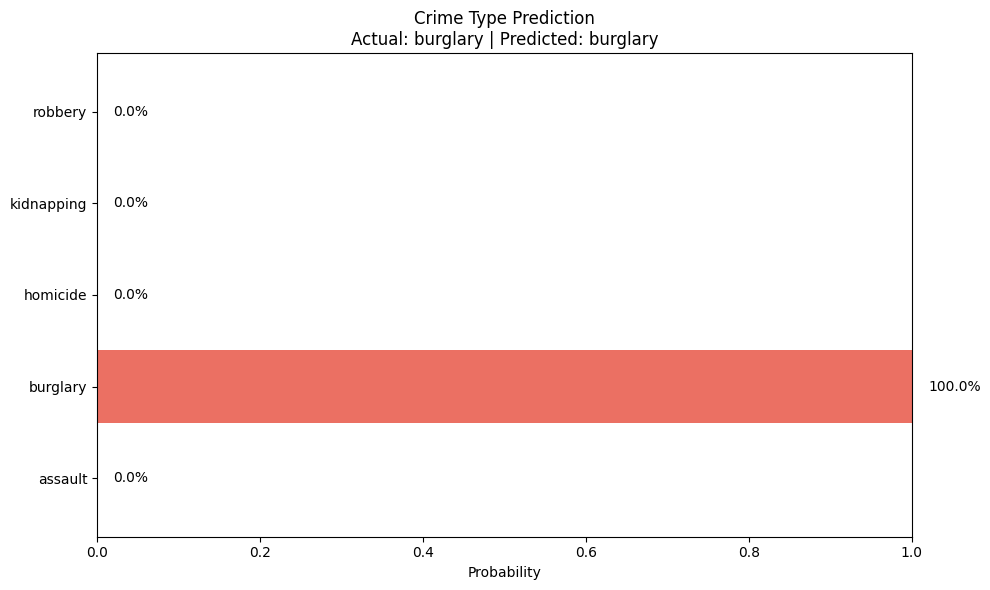

Hypothesis - Predicted: burglary (100.0%), Actual: burglary
Visualization saved to results/graph_visualization.png


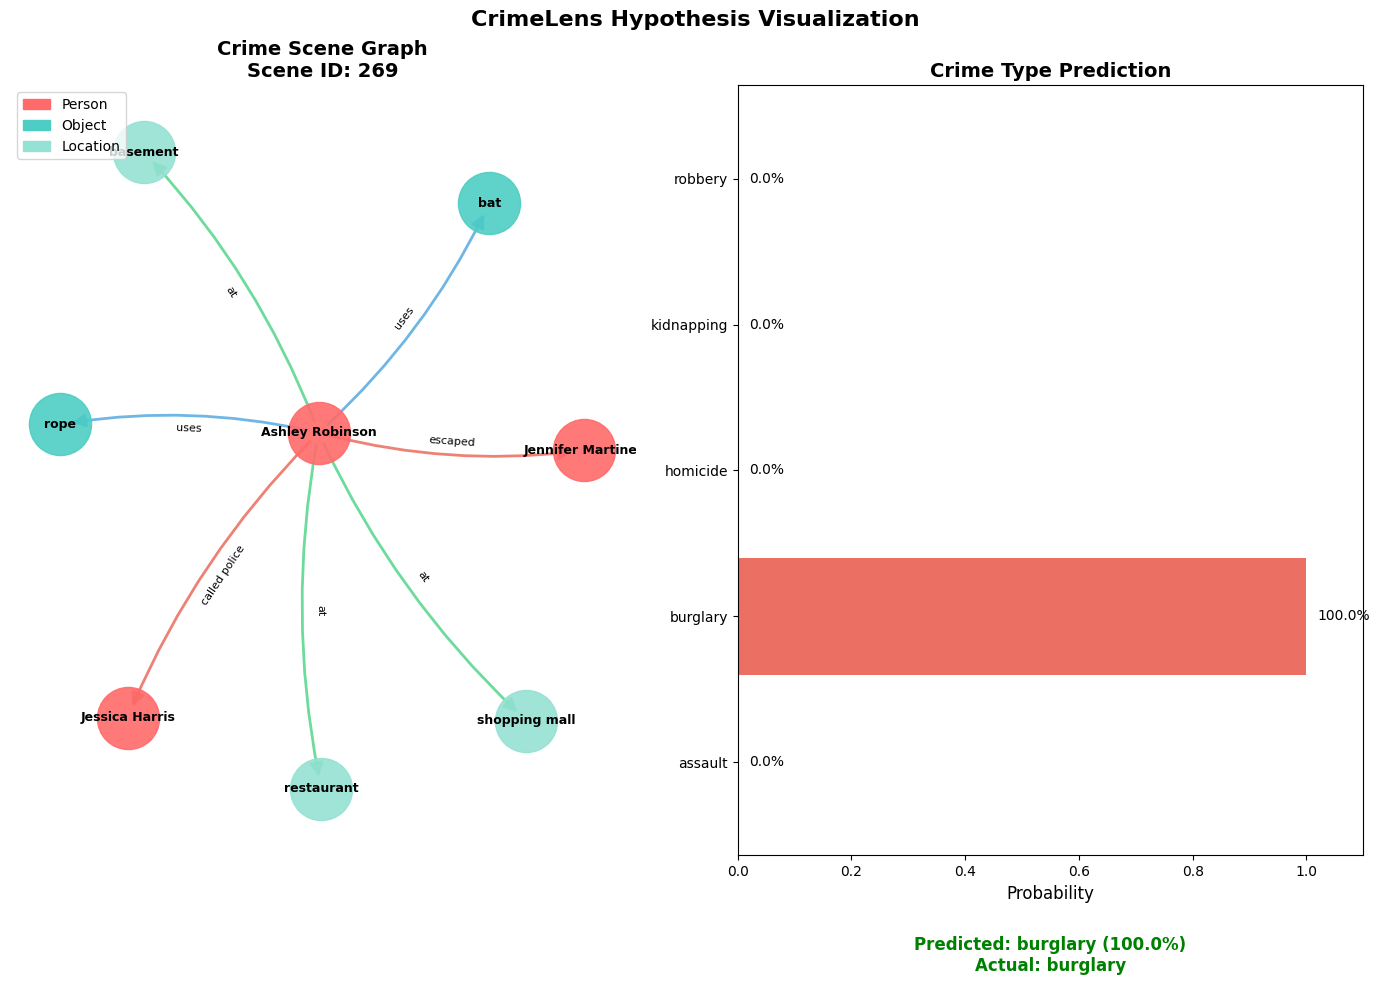

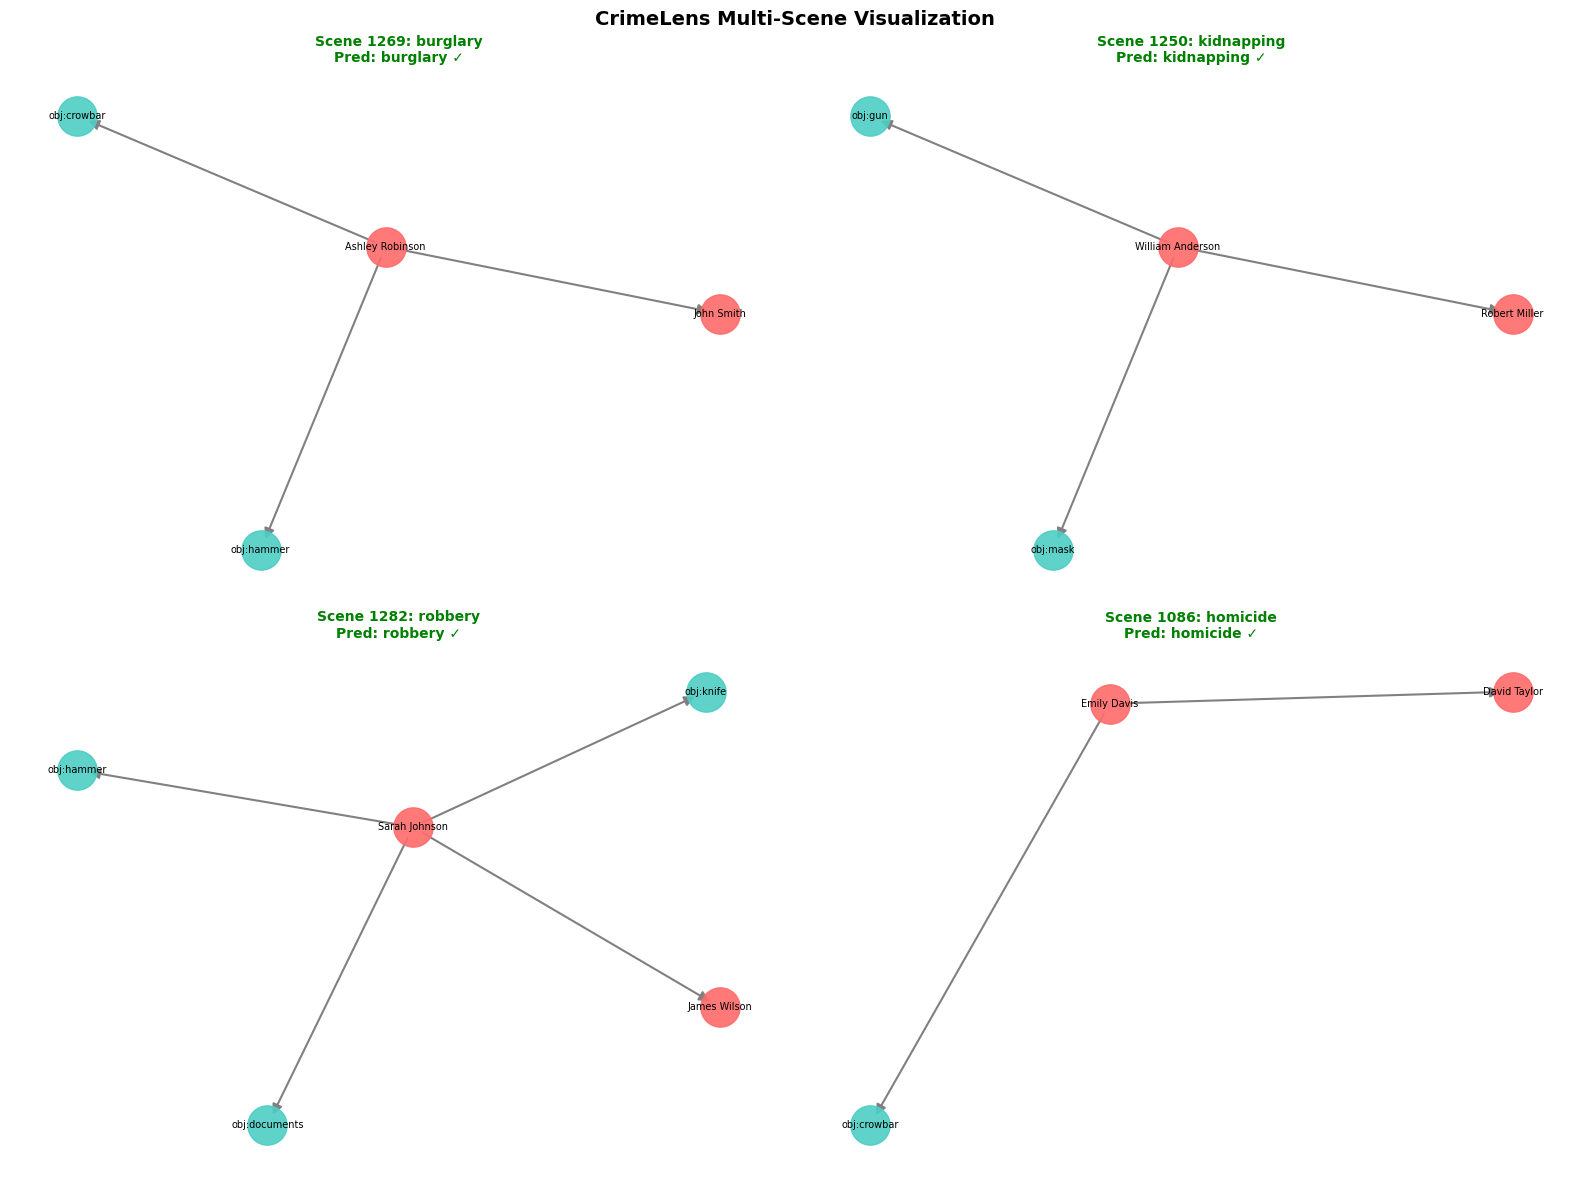

Explanation saved to results/gnn_explanation.png


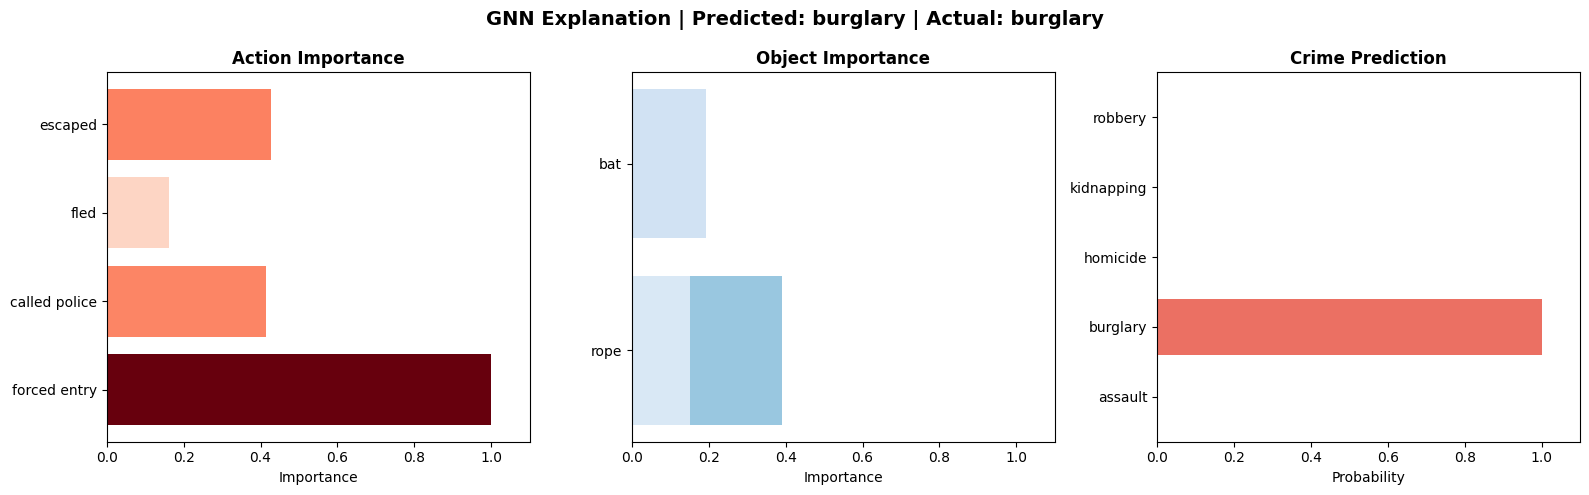

Explanation generated - Top action: forced entry

[STEP 6] Saving Summary
--------------------------------------------------

FINAL RESULTS
Random Forest             | 0.997 | ███████████████████████████████████████
Logistic Regression       | 0.987 | ███████████████████████████████████████
GNN (Ours)                | 0.980 | ███████████████████████████████████████

All artifacts saved to: results/
  - training_history.csv
  - training_curves.png
  - best_model.pt
  - model_comparison.csv
  - model_comparison.png
  - hypothesis_example.png
  - graph_visualization.png
  - multi_scene_visualization.png
  - gnn_explanation.png
  - experiment_summary.json


In [18]:
if __name__ == "__main__":
    # Option 1: Use your own data
    # from data_manager import DataManager
    # dm = DataManager("/path/to/data")
    # df = dm.getData()
    dm = DataManager("/Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/data/realistic_crime_data_2.csv")
    df = dm.getData()
    
    # Option 2: Use realistic synthetic data
    # from syntheticData_3 import generate_advanced_data
    # df = generate_advanced_data(n_scenes=1500, seed=42)
    
    # Run pipeline
    results = run_complete_pipeline(df, save_dir="results", epochs=200)